<h1>Math</h1>

In this section we're going to be introduced to the next project of this series, creating a reinforcement learning training bot 

---

<h3>RL Trader Section Introduction</h3>

Usually when people think about applying machine learning to the stock market, they usually think about it in terms of predicting the value of a stock which includes even just the direction like whether it will go up tomorrow or down tomorrow

Of course that information by itself doesn't do anything physically

We still need to sit down at our computer and make a trade

If we're talking about automated high frequency trading, then that's a different story

Even so let's say our model predicts that the stocks we are looking at will go up tomorrow

Does that mean we'll make a trade?

Maybe

But what if we're busy and we forget

Or what if we believe it's going to go up only slightly and then decrease rapidly 

Then probably we don't want to buy that stock

This is the key difference between traditional supervised and unsupervised learning versus reinforcement learning 

Supervised learning only makes a prediction, it doesn't actually take any action based on that prediction

We can predict tomorrow's stock price but we still have to choose whether we will act on that information or not

Reinforcement learning on the other hand, not only makes predictions but also takes actions in the environment that we provide

So in this notebook of the series, we are going to study how a reinforcement learning algorithm might take such actions in a stock trading environment

---

<h3>Rough Outline</h3>

Let's just go over a rough outline of how this is going to work

Currently we probably just think of stock prices as a simple time series dataset 

At this time it has this value at the next time it has this other value and so on

That sounds more appropriate for a recurrent neural network rather than reinforcement learning

So what makes this a reinforcement learning problem

---

<h3>A matter of perspective</h3>

Well it's a matter of perspective

Imagine let's say we're hooked up to a stock trading API 

Using this API you can call functions which do real world financial transactions

So if we call `api.buy('GOOG',10)`, that means we're going to buy `10` shares of `Google` stock

If each share is worth fifty dollars, that means five hundred dollars is going to be deducted from our bank account and instead we will now own 10 shares of Google

---

Let's say we call `api.sell('AAPL',5)`, that means we just sold five shares of Apple stock

If one share of Apple is worth thirty dollars then we will now receive one hundred fifty dollars in our bank account and we will own five less shares of Apple stock than we did before

---

Importantly we can see that the act of calling these functions is an action

We might think of our state as information such as recent stock prices, how much cash we have to buy more stocks, how many shares of each stock we own, the values of those stocks and so on

The environment is the actual stock market

It's inherently random because we can't really predict what's going to happen to tomorrow's stock price

But our actions affect the environment

In other words these are all the ingredients we need to specify our problem as a reinforcement learning problem

We can perform actions such as buy and sell in the environment and our state is made up of information about various stocks in our own portfolio and the environment is the stock market itself

The reward is some function of the money we made or lost 

---

<h3>Are we a reinforecement learning agent?</h3>

Something useful to try, which is probably something many of us have done already is to think about how we ourselves are a reinforcement learning agent

When we are looking at a stock and trying to decide whether or not to purchase some shares, we generally want to follow the rule buy low sell high

<img src='extras/59.1.PNG' width='400'>

So for example here we can see a dip in value

This would be a really good time to buy

We can also see a peak

This would be a really good time to sell, well only if we need the money

Hopefully we are investing in something where the general trend is always going up, so if we don't need the money then the best thing to do is just let it sit and continue to increase in value

Of course the problem is that in the real world we are trying to make these decisions without knowledge of the future

How do you know if the most recent price is a dip or a peak

In fact we do not

And so perhaps this is a job best left for the machines

<h1>Math</h1>

In this section we are going to describe the environment we'll be working with in the following sections

---

<h3>Enviroment Description</h3>

Firstly because we'll be working with historical stock data, this is a simulation

Of course we would not want to try such an experiment with real money

So really our job is to figure out how to build an environment object in code that simulates the stock market 

---

<h3>Enviroment API</h3>

In general, Here's how we can think of the API for an environment 

By the way, If we're familiar with OpenAI Gym then this is probably just review for us

But it's good to go over this anyway

So the idea is this

```python
env = MyTradingSimulationEnv()
done = False
state = env.reset() # bring us back to initial staate
while not done:
    action = get_action(state) # could come from our agent
    # perform the trade, 'info' contains portofolio value
    next_state, reward, done, info = env.step(action)
    state = next_state
```

First we are going to instantiate an environment object

Then we are going to initialise a boolean `done` flag equal a `False`

We are also going to call `env.reset()` which puts us back into the starting position for this environment and returns the initial state

As a side note this state vector may not be at a good scale to pass into a neural network

As we recall, remember that we like to normalize data before passing it into a neural network or linear regression 

So keep in mind that we can do this as an optional step 

Then we are going to enter a loop which only quits when `done` becomes `True` 

Inside the loop, we are going to choose an action to perform in the environment

This might come from our agent but that's not a necessary detail at this stage because we are only thinking about the API for the environment

We could just as easily choose a random action although most likely this will lead to a suboptimal reward

The next step is to actually perform the action in the environment

We do that by calling `env.step()` and passing in the action as an argument 

This will return a few things

First it returns the next state

Second it returns the reward for arriving in the next state

Third it returns a done flag to tell us whether or not the episode is over

Finally it returns and info dictionary which can tell us additional information about the environment

This one is not strictly necessary and in fact it's empty for many environments but for us we're actually going to populate the info dictionary to tell us the current value of our portfolio

This is not a part of the state but can be calculated from the state variables

Thus it's easier to simply calculate it inside the environment and return it along with everything else

Finally we assign the next state variable to the state variable in the case where on the next step the agent needs to use the state to choose an action

---

So that's pretty simple and we'll find that in general no matter what environment you are looking at it's going to have an API just like what we saw 

The questions we really want to answer now are what should the state be and what should the action be and what should the reward be

The reason we need to discuss these is because there are an endless number of possibilities and complications

We are necessarily going to have to simplify the problem a little bit but first lets explain why this simplification is necessary

---

<h3>State</h3>

Let's start with the state

There are many things we could consider here

First we can think of it exactly like a time series problem

Look at the pattern of stock movements in the past and from that make a decision

That's probably the first thing we would do when we decide if we're going to buy or sell a stock

However there are other things to consider

We also have to ask do we own enough cash to buy the stocks we want to buy 

And given the prices of existing shares we own, is it worth it to sell them in order to get more cash to buy a different stock

So in fact this can become a complex decision problem

---

We are going to borrow some ideas from a paper called `Practical Deep Reinforcement Learning Approach for Stock Trading`

This approach used a more advanced reinforcement learning technique known as `DDPG` but we can apply a few of the ideas they proposed

So here's how we're going to represent our state

It will consist of three parts 

First we're going to record how many shares of each stock we own

So for example if we're looking at Apple Motorola and Starbucks, `[3 5 7]` means we own three shares of Apple five shares of Motorola and seven Shares of Starbucks 

Second, we're going to list out the current share price of each stock

So this means Apple is trading at fifty dollars per share

Motorola is trading at twenty dollars per share

And Starbucks is trading at thirty dollars per share

Finally the last value of the state is how much pure cash we have

That's cash that's not invested in any stock which just sits there and doesn't gain any interest 

So let's say we have one hundred dollars in cash, then our total state vector will be `[3 5 7 50 20 30 100]` 

We should be able to confirm that if we have $N$ stocks than the size of our state vector will $2N+1$

---

<h3>Actions</h3>

Next, let's consider the actions 

Again if we consider the sheer amount of possibilities the action space would be extremely large 

For any given stock, we have three possible options

We can sell We can buy or We can hold, which means do nothing

Now we might think three is not bad

But now remember we have three stocks to consider 

For each of these, we can exercise any of the three options above

So that gives us $3^3$ possible actions or $27$ actions

For example our action vector maybe `[sell sell sell]` which means sell our Apple shares sell our Motorola shares and sell our Starbucks shares 

Or it might be `[buy sell hold]` which means buy Apple shares sell Motorola shares and do nothing with our Starbucks shares 

However this is still not the end of the story because this doesn't say anything about how many shares to buy or sell

If we own ten shares of a stock, we can sell anywhere from zero to 10 of those shares

Luckily we are going to simplify this problem a little bit

---

<h3>Actions (Simplified)</h3>

So here's how we're going to treat actions in our example

It's going to be extremely simplified compared to how things work in the real world but it's a decent start

First we're not going to consider any transaction costs

For example if we buy shares using our bank's investing platform usually that would cost us ten dollars or so

For us it will be zero 

Next when we sell, We will always sell all of our shares for that stock

So let's say we own 10 shares of Apple stock and we decide to sell

That means we sell all 10 shares 

Secondly when we buy we are going to buy as many shares as possible for the stock we choose to buy

Now we might wonder, if we choose multiple stocks to buy and we want to buy as many as possible, how can we do that?

Well it's kind of ambiguous

We might think we want to choose the stocks in such a way that leads to using up as much cash as possible

But in fact this is actually a hard problem known as the knapsack problem

So what we're going to do is we're going to take a simple greedy approach 

Loop through every stock and buy one share of each stock and keep doing that in a loop until we run out of money

Third we will also sell the stocks we want to sell before we buy anything 

That will leave us with more cash that we can use to buy new stocks 

This may seem like a very course approach, but in fact this already leaves us with 27 possible actions which means our neural network will have to approximate 27 different values which is pretty large already 

And so an action in this environment is not just making a single trade but rather it will involve doing all the steps in the specified order

---

<h3>Reward</h3>

Finally we have the reward

This one is simple

The reward will just be the change in the value of our portfolio

Now it's worth thinking about how well we calculate the value of our portfolio 

As an example suppose, we own 10 shares of Apple 5 shares a Motorola and 3 Shares of Starbucks

The corresponding share prices are 50 dollars for Apple 20 dollars for Motorola and 30 dollars for Starbucks

Let's also suppose we have 100 dollars in cash not invested in any stock

Then the total value of our portfolio will be $\text{Value} = 10 \times 0 + 5 \times 20 + 3 \times 30 + 100 = 790$

---

<h3>Portfolio Value</h3>

In general, if we store the shares we own in a vector called $s$ and we store the corresponding share prices in an array called $p$ and we store the amount of cash we have in a variable called $c$ then the total value of our portfolio can be calculated as follows

It is equal $s^Tp + c$, the reward then we'll just be the difference between these two, comparing the most recent timestep and the previous timestep

---

<h3>Summary</h3>

To summarize this section, let's recap the important points about the environment and its implementation

First our environment will be an object that mimics the OpenAI Gym API 

So it will have functions like `reset` and `step` which returns all the information we need to implement our reinforcement learning program

Next for our environment we'll be considering three stocks Apple, Motorola and Starbucks 

Next, our state is a vector with three pieces of information

First it includes the number of shares of each stock that we want to consider

Second it includes the share price for each of those stocks

Third it includes the amount of cash we have that's not invested in any stock

Next our actions are a simplified subset of the large number of actions we can perform in the real world

We also assume there are no transaction costs

Simply put, we have three options for each stock buy sell or hold

We'll take an all or nothing approach where if we buy we're going to buy as many shares as possible and if we sell we're going to sell all of the shares we own

And these three actions can be applied in any combination for each stock we own

So if we're considering three stocks then we'll have $3^3$ possible actions 

We'll notice that even with just three stocks and a much simplified action space we still have quite a large number of actions 

So if we have $N$ stocks we would have $3^N$ possible actions

It grows exponentially with the number of stocks we own, so encoding the actions in this way will not scale if we have many stocks to consider 

Finally the reward is just the change in value of our portfolio from the previous steps to the current step

The value of our portfolio is just the price of each stock we own times the number of shares we own plus any on invested cash we have

<h1>Math</h1>

<h3>How to Model Q(s,a)</h3>

In this section we are going to describe the architecture of our model since it's going to be a little different from how we previously described it in the theory sections

It's still going to be a linear regression and it's still going to model the action value $Q(s,a)$

But the idea is we're going to treat the model more like how it's done in a modern deep reinforcement learning, that is reinforcement learning with neural networks

---

The big difference now is that instead of transforming the tuple $(s,a)$ into a feature vector, we'll only use the state as input and we'll have a separate output for each action

As a side note we could still transform the state $s$ but the important point is that we do not incorporate the action into the feature vector 

So as an example consider our trading environment

In this case our state is of size seven

There is three for the number of shares of each stock we own, three for the share prices and one for the amount of cash we have uninvested

The number of actions is $3^3 = 27$

These represent the different permutations of buy sell and hold that we can perform for each stock

Thus our weight matrix will be of size $7 \times 27$ and our bias vector will be of size $27$

<img src='extras/59.2.PNG' width='250'>

note : the size of the neural network is different in our case, just showing the architecture

$\large Q(s,:) = W^Ts + b$

note : The colon is numpy notation

---

<h3>Training</h3>

This has implications for the training process which we would like to describe in this section

Recall that in order to update our model with Q-learning we're going to treat it like a supervised learning problem and do one step of gradient descent for each $s,a,r,s^\prime$ tuple we encounter 

The target, if we haven't reached the terminal state is $r + \gamma \max_{a^\prime} Q(s',a')$

If we have reached a terminal state the reward is just $r$

The input to the model is just $s$ which we can assume we've already done a feature transformation on if we need to 

Importantly recognize that these targets are scalars

---

<h3>Linear Regression with 1 output</h3>

Now normally when we're doing linear regression and we have just one output we perform linear regression like so 

The target is a scalar and the output prediction is also a scalar 

$W$ is a vector and the bias term is a scalar 

So we do 

$$\large w = w - \eta \frac{\partial J}{\partial w}, b = b - \eta \frac{\partial J}{\partial b}$$

And so we just keep repeating that until our cost converges

---

<h3>Linear Regression with Multiple Outputs</h3>

But what happens when we have multiple outputs

Our target is still a scalar $r + \gamma \max\limits_{a^\prime} Q(s',a')$

But now the output prediction is a vector

We have an output prediction for $Q(s,a)$ for all actions $a$

---

<h3>What do we want?</h3>

Conceptually here's what we want to do 

We have to ask ourselves which action did we actually calculate the target for

We calculate it for $Q(s,a)$ the prediction

This is the action we actually chose to perform in the environment

The target is not for the other actions

Therefore any weights corresponding to those actions should not be updated

Hence the updates should look like this where we find the gradients only for the action we performed

$$\large J = (r + \gamma \max_{a'} Q(s',a') - Q(s,a))^2$$

$$\large W_a = W_a - \eta \frac{\partial J}{\partial W_a}, b_a = b_a - \eta \frac{\partial J}{\partial b_a}$$

And we update the weights corresponding to that action

---

<h3>Practical Implementation</h3>

But that was just conceptual

We could implement it like that but we choose to implement it like this since it makes things a little nicer if we want to extend this model in the future 

For example we could do something like plug in a tensorflow model and build a neural network instead

So here's what we do

Since our model has $K$ outputs we have $K$ output predictions

Let's say for simplicity's sake that $K=3$, so we have 3 actions $a_1,a_2,a_3$ and let's say we perform the action $a_2$ in the environment, so those are the weights we want to update and that's the action that the target corresponds to 

But in a model like we would have with tensorflow or scikit-learn our targets must have the same shape as our output prediction

Therefore we must have $K$ targets as well

We know what the target for a $Q(s,a)$ should be, that's the target we calculated earlier 

But in order for this to be equivalent to what we discussed previously we want the error for all the other actions to be $0$ 

In order to achieve this, we can simply make the target for those actions equal to the prediction 

In that way the waits for those actions will not be updated

---

<h3>Momentum</h3>

Another small modification we are going to make is that instead of plain vanilla gradient descent we are going to use gradient descent with momentum


$$\large v(t) = \mu v(t-1) - \eta g(t) \\ g(t) = \text{gradient at time t} \\ \mu = \text{momentum term (0.9,0.99,etc)} \\ \eta = \text{learning rate}$$

$$\large w(t) = w(t-1) + v(t)$$

Momentum has been shown to speed up training significantly


The basic idea is this

Instead of only taking a small step in the direction of the gradient on each iteration we will keep around the old gradients in a term which will call the velocity or the momentum $v(t)$ 

In this way, we'll keep going in the direction we were previously going, just like how momentum works in physics 

At each step, $v(t)$ is updated by taking a small fraction of the old $v$, $v(t-1)$ and then adding the new gradient $g(t)$ 

The momentum term $\mu$ is usually a number just below $1$, like $0.9,0.99$

The parameter $w$ changes by $v(t)$ on each iteration

---

<h3>Momentum Analogy</h3>

To give ourselves an intuitive analogy, we can think of it as the difference between riding a bicycle and walking 

When we're walking, we take a step, after we step we land in a new place, in order to keep moving we must take another step

Compare that to riding a bicycle on a horizontal road 

Every time we pedal we will accelerate forward, but importantly even if we stop pedaling we still keep moving forward although eventually we will
slow down and stop 

So our momentum gradually decreases over time unless we add new movement by pedaling more so we can interpret that as the gradient

---

<h3>From Expected Value to Momentum</h3>

Now we might think, this significantly deviates from how we derived the Q-learning update

It's morphing into something different at each step of the way

But if we follow the logic it makes sense

First we looked at Monte Carlo methods which use the sample mean to estimate the expected value of the return

That seems logical because that's essentially the basis for Monte Carlo methods

Second, we realise that we can convert the sample mean expressionis into an expression that resembles gradient descent with a learning rate of 1/N

In fact this is gradient descent where the latest sample is the target and the error function is just the squared error 

Since it's just gradient descent, there is nothing wrong with us using a constant learning rate instead of the decaying learning rate

In fact a constant learning rate is better since our policy changes over time in value iteration and hence the distribution of our samples is changing over time

So that seems logical as well

Third we go from Monte Carlo to temporal difference methods where we simply replace the target which was the full return into a one that prediction of the return

That's also a logical step, nothing wrong with that

Finally since this is just gradient descent, where we have some input and some target and the squared error there is also nothing wrong with us using variance of gradient descent which improve the learning process such as momentum

---

<h3>Summary</h3>

To summarisee this lecture here's what we did

First we described a new way of using a linear regression model to approximate the Q-table

We use only the state as input and the number of output nodes corresponds to the number of actions

In this way each output node corresponds to $Q(s,a)$ for a different action

Then we looked at how we would update this model from two different perspectives

First we noted that the target is only a scalar while we have $K$ different outputs

We know that the target corresponds only to the action we took

And so one thing we can do is index the weight matrix and bias vector by that action when we do the update 

Another way to do it is to make a target which also has size $K$ but make it so that the target equals the prediction for any action we didn't take

Finally we noted that instead of plain vanilla gradient descent we would use momentum to speed up training

<h1>Math</h1>

In this section we are going to discuss the layout and design of our reinforcement learning trading bot

---

<h3>RL Trader Layout and Design</h3>

First at a very high level, we are going to have two modes of operation train and test

As usual we want all of our training data to be in the past and all of our test data to be stock prices that came after the training data

<img src='extras/59.3.PNG' width='500'>

So we are going to train our agent to maximise its reward over an episode using only the training data

Then we are going to use this trained agent on the test data to see what the value of our portfolio is by the end of the test period

---

<h3>Using the enviroment</h3>

To start let's think about how this would work if we had access to all the objects we needed

Even without the agent this will help us organize the majority of our code

The main part of the code will look something like this

```python
env = Env()
agent = Agent()
portfolio_values = []
for _ in range(num_episodes):
    val = play_one_episode(agent,env)
    portofolio_values.append(val)
plot(portofolio_values)
```

First create an instance of the environment 

Next create an instance of the agent

Don't worry about what this does yet 

Then in a loop we're going to have a function called `play_one_episode` which accepts the environment and the agent and returns the value of the portfolio at the end of the episode

When our loop is done we're going to save the portfolio values for later so that we can plot them and analyze them

So this is pretty simple 

But now we have to figure out what should go in the function `play_one_episode`

---

<h3>play_one_episode</h3>

So here's what the `play_one_episode` function might look like

```python
def play_one_episode(agent,env):
    s = env.reset()
    done = False
    while not done:
        a = agent.get_actions(s)
        s_prime,r, done,info = env.step(a)
        if train_mode:
            agent.train(s,a,r,s_prime,done)
        s = s_prime
    return info['portfolio value']
```

As always we start by resetting the environment to get back to the initial state

Next we initialize our `done` flag to `False` and enter a loop that only quits when `done` becomes `True` 

Inside the loop we choose an action

Now at this point we know that this action is coming from our agent but will defer how the agent works until later 

Next we're going to call the `env.step()` function to perform the action and get back the next state, reward and so on

Next we're going to check if our script is in train mode, if it is then we have to train our agent

This will be some variant of gradient descent as usual 

Finally we'll set the current state to be the next state for the next iteration of this loop

When we're done we'll return the value of our portfolio

---

<h3>Normalising data</h3>

One additional detail to keep in mind is that our data is not yet normalized

$$\large z - \frac{x-\mu}{\sigma}$$

We can imagine that our state which is composed of three parts can have vastly different ranges

The first part consists of the number of shares we own, the second part consists of share prices and the third part consists of how much cash we have sitting uninvested

So we'll want to normalize this data

We can do this very simply 

Whenever we get a new state, we'll have a scalar object from scikit learn which will take our state and standardize it to have zero mean and unit variance

So not a huge addition to our previous code

```python
state = env.reset()
state = scaler.transform(state)
...
next_state, reward, done, info = env.step(action)
next_state = scaler.transform(next_state)
```

---

<h3>Enviroment</h3>

Next, let's imagine what our environment objects will actually look like 

```python
class Enviroment:
    def __init__(self, stock_prices, initial_investment):
        self.pointer = 0
        self.stock_prices = stock_prices
        self.initial_investment = initial_investment
    def reset(self):
        # reset pointer to 0 and return initial state
    def step(self,action):
        # perform the trade, move pointer
        # calculate reward, next state, portfolio value, done
```

First it's going to accept a time series of stock prices as input into its constructor 

We'll also have a pointer to tell us what day it is, so we know the current stock prices 

We'll also want to know how much cash we initially start with, our initial investment 

From this we can do everything we need to do 

Our reset function will bring our pointer back to the beginning of the time series and recalculate our state which of course should be all cash and no investment 

Our step function, will take an action and then buy and sell the stocks specified by the action 

Then it'll set our pointer to the next day's stock prices

We'll also calculate the next state and the portfolio value

From this we can calculate the reward

The done flag will simply be set to `True` if we reach the end of our time series 

So that's basically it for the environment we have the constructor, a `reset` function a `step` function

---

Finally let's consider our agent object which is complicated but no more complicated than the environment

```python
class Agent:
    def __init__(self):
        self.model = Model()

    def get_action(self,s):
        # calculate Q(s,a) take the argmax over a

    def train(self,s,a,r,s_prime,done):
        input = s
        target = r + gamma * max{ Q(s_prime,:) } or r if done = True
        self.model.sgd(input,target) # gradient descent w/ momentum
```

So what are the essential functions of the agent 

We'll need a `get_action` function which accepts as input a state and decides what actions to perform in the environment

And because this is Q-learning it's going to use the Q-learning rule or some variant of it like epsilon-greedy 

We'll need a gradient descent function which does the following

First it's going to take in a tuple of data: state, action, reward, next state and done flag

We can use this to calculate a supervised learning dataset which consists of input and target pairs which is what we need for our model

The input into our model is the state the target will be the reward if the next state is terminal or in other words `done` is `True`

If the next state is not terminal then we use the usual Q-learning target $r + \gamma \max\limits_{a^\prime} Q(s^\prime,a^\prime)$

Once we have our data set we can do one iteration of gradient descent as usual

As a side note we'll be incorporating momentum into our model as well which helps the model converge faster

---

<h3>Summary</h3>

All right, so that's it for this section

There are certainly more details we haven't yet discussed since this was designed to just give us an overview 

At this point we understand that our script will have a train mode and a test mode

In both cases there will be a main loop where we call `play_one_episode` again and again 

Playing one episode involves basically just going back and forth between the agent and the environment 

The environment produces states and rewards 

The agent takes in states and returns actions to perform in the environment

During train mode, the agent will store the states, actions and rewards and perform Q-learning updates in order to train the Q-function approximater

<h1>code</h1>

Quick revision on loss & gradients

Our loss function (mean squared error) $J$ is defined as 

$$\large J = \frac{1}{NK} \sum^N_{n=1}\sum^K_{k=1} (y_{nk} - \hat y_{nk})^2$$

$$\large \text{shape}(y) = \text{shape}(\hat y) = (N,K) $$

note : recall that our model is a linear regression with multiple outputs, if we call the number of samples $N$ and the number of outputs $K$, then $y$ will be of size $N \times K$ and when we make a prediction it will be the same size, when we calculate the mean squared error we take the sum of the squared errors divided by the total number of values, in our case the total number of values is $N \times K$

$$\large \frac{\partial J}{\partial \theta} = \frac{2}{NK} \sum^N_{n=1} \sum^K_{k=1} (\hat y_{nk} - y_{nk}) \frac{\partial \hat y_{nk}}{\partial \theta}, \text{ for } \theta = \{W,b\}$$

In [1]:
# here we gooooo
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
# first we create our enviroment
class Stock_Market:
    def __init__(self,stock_prices_file='datasets/aapl_msi_sbux.csv',initial_investment=20000):
        # here we read the data
        self.all_stock_prices = pd.read_csv(stock_prices_file).to_numpy()
        self.initial_investment = initial_investment
        self.pointer = 0
        self.num_stocks = self.all_stock_prices.shape[1]
        # lets split data to train and test
        self.train = int(len(self.all_stock_prices)*0.5)
        self.stock_prices = self.all_stock_prices[:self.train]
        self.all_actions = ['buy','sell','hold']
        self.state = np.concatenate(([0,0,0],self.stock_prices[0],[self.initial_investment]))
        self.uninvested = self.initial_investment
        self.portfolio_values = [self.initial_investment]
        
    def set_mode(self,training=True):
        if training==True:
            self.stock_prices = self.all_stock_prices[:self.train]
        else:
            self.stock_prices = self.all_stock_prices[self.train:]
    
    def reset(self,training=True):
        self.pointer = 0
        self.set_mode(training)
        self.uninvested = self.initial_investment
        self.state = np.concatenate(([0,0,0],self.stock_prices[0],[self.initial_investment]))
        self.portfolio_values = [self.initial_investment]
        return self.state
    
    def step(self,action):
        N = self.num_stocks
        prices = self.stock_prices[self.pointer]
        money = self.state[-1]
        state = self.state
        # first we sell as much as we can
        buy_stocks = []
        for s,a in zip(range(N),action):
            if a == 'sell':
                num_stock = self.state[s]
                price_stock = prices[s]
                money += num_stock*price_stock
                state[s] = 0
            if a == 'hold':
                # we have same number of stocks as previous state
                # so we do nothing 
                pass
            if a == 'buy':
                # save which stocks to buy
                buy_stocks.append(s)
        # next we round-robin buy the stock
        if len(buy_stocks) != 0:
            i = 0
            bought = [True]*len(buy_stocks)
            while True:
                s = buy_stocks[i]
                price = prices[s]
                if money >= price:
                    state[s] += 1
                    money -= price
                    bought[i] = True
                else:
                    bought[i] = False

                # rotate around array
                i = (i+1)%len(buy_stocks)
                
                # if we cant but any stock then we quit
                if not True in bought:
                    break
        state[-1] = money
        value = state[:N]@state[N:-1] + state[-1]
        self.portfolio_values.append(value)
        self.pointer += 1
        # get prices for next day
        state[N:-1] = self.stock_prices[self.pointer]
        reward = self.portfolio_values[self.pointer] - self.portfolio_values[self.pointer-1]
        done = False
        if self.pointer+1 == len(self.stock_prices):
            done = True
        return state,reward,done,{'portfolio value':value}

In [3]:
# here is our model
class Model:
    def __init__(self,D,K):
        # our model has the parameter W
        # W is of size DxK
        # D is the dimensionality of our state
        # in our case 7
        # K is the size of our action space
        # recall for 3 actions and 3 stock thats 3**3 = 27
        self.W = np.random.randn(D,K)/np.sqrt(D*K)
        # recall also the bias term is of size K
        self.b = np.zeros(K)
        # momentum terms
        self.vW = 0
        self.vb = 0
        
    def sgd(self,x,t_a,a,alpha=0.01,momentum=0.9):
        y = x@self.W + self.b
        # now y is of size K, a value for each action
        # recall that t however is a scalar, a single value for the action we took
        # we can just perform gradient descent on the needed weights using indexing
        # but lets do what we discussed in the math sections
        # the target becomes the prediction except for the selected action
        # in this way the error for all other weight is zero
        t = y.copy()
        t[:,a] = t_a        
        delta = y-t # we will do gradient descent
        num_values = np.prod(y.shape)
        # the 2 and num values would surely be absorbed into the learning rate
        # but just to make it identical to what a tensorflow model would do
        # we calculate the exact gradient
        # also this way it responds better to the change in input size
        gW = 2*(x.T@delta)/num_values
        gb = 2*(x.T@delta).sum(axis=0)/num_values
        
        # next we add momentum
        self.vW = momentum*self.vW - alpha*gW
        self.vb = momentum*self.vb - alpha*gb
        
        self.W += self.vW
        self.b += self.vb
        


In [4]:
# next for our agent
class Agent:
    def __init__(self,env):
        D = len(env.state)
        num_stocks = env.stock_prices.shape[1]
        num_actions = len(env.all_actions)
        K = num_actions**num_stocks
        self.model = Model(D,K)
        self.D = D
        self.K = K
        self.num_actions = num_actions
        self.num_stocks = num_stocks
        # we need to know that
        # 0 : buy, 1 : sell, 2 : hold
        self.idx2act = {num:act for num,act in zip(range(len(env.all_actions)),env.all_actions)}
        self.scaler = StandardScaler()
        self.scaler.fit(self.gather_states(env))

    # gather states from one epoch
    # we need these so our scaler fits on them
    def gather_states(self,env,episodes=100):
        states = []
        for episode in range(episodes):
            state = env.reset()
            states.append(state.copy())
            done = False
            while not done:
                a = np.random.choice(range(self.K))
                state,reward,done,info = env.step(self.num_to_action(a))
                states.append(state.copy())
        return np.array(states)
        
        
    def epsilon_greedy(self,best_action,eps=0.1):
        if np.random.random() < eps:
            return np.random.choice(range(self.K))
        else:
            return best_action
        
    def num_to_action(self,action):
        # simply convert number to K system
        base = self.num_actions
        num = action
        base_num = ""
        while num>0:
            dig = int(num%base)
            if dig<10:
                base_num += str(dig)
            else:
                base_num += chr(ord('A')+dig-10)  #Using uppercase letters
            num //= base
            base_num = base_num[::-1]  #To reverse the string
        while len(base_num) < self.num_stocks:
            base_num = '0' + base_num
        return [self.idx2act[int(i)] for i in base_num]
        
    
    def get(self,s,get=None):
        Q = s @ self.model.W + self.model.b
        best_action = range(self.K)[np.argmax(Q)] # the argmax returns the index not the action itself
        max_Q = np.max(Q)        
        if get == 'value':
            return max_Q
        if get == 'action':
            return best_action
        
        return max_Q,best_action

    
    def train(self,s,a,r,s_prime,done):
        input_ = s
        if done:
            target = r
        else:
            target = r + self.gamma* self.get(s_prime,get='value')
        # we also need to pass the action
        # so that we update the weights for only that action
        self.model.sgd(input_,target,a,self.alpha,self.momentum)
        # update epsilon
        # note that should we set epsilon to 0
        # we end up with a deterministic model
        # so eps_min != 0
        self.eps = max(self.eps*self.eps_decay,self.eps_min)

            
    def play_one_episode(self,env,training=True):
        s = env.reset(training)
        s = self.scaler.transform([s])
        done = False
        while not done:
            # get best action
            # pass training to decide whether or not to use epsilon greedy
            a = agent.get(s,get='action')
            if training:
                a = self.epsilon_greedy(a,self.eps)
            # our action is just an integer now
            # we need to convert it to an action
            # for ex 0 --> [buy buy buy]
            s_prime,r, done,info = env.step(self.num_to_action(a))
            s_prime = self.scaler.transform([s_prime])
            if training:
                agent.train(s,a,r,s_prime,done)
            s = s_prime
        return info['portfolio value']      
    
    def learn(self,env,episodes=2000,gamma=0.95,alpha=1e-2,eps_start=1,eps_min=0.01,eps_decay=0.995,momentum=0.9):
        self.gamma = gamma
        self.alpha = alpha
        self.momentum = momentum
        self.eps = eps_start
        self.eps_min= eps_min
        self.eps_decay= eps_decay
        portfolio_values = []
        

        for episode in range(episodes):
            value = self.play_one_episode(env)
            portfolio_values.append(value)
            print('episode: ',episode+1,' / ',episodes)
            print('Portfolio value at end of episode: ',value)
                
        print('Average end-portfolio value: ',np.mean(portfolio_values))
        plt.plot(portfolio_values)
        plt.title('Portfolio Values at end of each epoch')
        plt.show()
        

In [5]:
env = Stock_Market()
agent = Agent(env)

episode:  1  /  2000
Portfolio value at end of episode:  21746.714099999022
episode:  2  /  2000
Portfolio value at end of episode:  20949.690900000278
episode:  3  /  2000
Portfolio value at end of episode:  22441.942499999444
episode:  4  /  2000
Portfolio value at end of episode:  23836.006299999797
episode:  5  /  2000
Portfolio value at end of episode:  28700.37249999976
episode:  6  /  2000
Portfolio value at end of episode:  30252.875000000156
episode:  7  /  2000
Portfolio value at end of episode:  25128.35000000113
episode:  8  /  2000
Portfolio value at end of episode:  24937.43999999972
episode:  9  /  2000
Portfolio value at end of episode:  31052.00749999985
episode:  10  /  2000
Portfolio value at end of episode:  30021.514999999694
episode:  11  /  2000
Portfolio value at end of episode:  33740.90750000053
episode:  12  /  2000
Portfolio value at end of episode:  34514.442400000866
episode:  13  /  2000
Portfolio value at end of episode:  25937.054000000324
episode:  14 

Portfolio value at end of episode:  37550.30779999752
episode:  110  /  2000
Portfolio value at end of episode:  37572.8417999995
episode:  111  /  2000
Portfolio value at end of episode:  40377.855800003206
episode:  112  /  2000
Portfolio value at end of episode:  48882.232999999986
episode:  113  /  2000
Portfolio value at end of episode:  32797.35399999978
episode:  114  /  2000
Portfolio value at end of episode:  40168.320499998634
episode:  115  /  2000
Portfolio value at end of episode:  44587.81700000122
episode:  116  /  2000
Portfolio value at end of episode:  42764.60259999758
episode:  117  /  2000
Portfolio value at end of episode:  45297.193399998956
episode:  118  /  2000
Portfolio value at end of episode:  31047.245299999307
episode:  119  /  2000
Portfolio value at end of episode:  47185.34629999964
episode:  120  /  2000
Portfolio value at end of episode:  48198.32250000206
episode:  121  /  2000
Portfolio value at end of episode:  39644.15789999922
episode:  122  /  

episode:  216  /  2000
Portfolio value at end of episode:  32731.294699997856
episode:  217  /  2000
Portfolio value at end of episode:  38700.134799999214
episode:  218  /  2000
Portfolio value at end of episode:  45085.19189999512
episode:  219  /  2000
Portfolio value at end of episode:  42609.29619999634
episode:  220  /  2000
Portfolio value at end of episode:  46953.86899999968
episode:  221  /  2000
Portfolio value at end of episode:  38359.965599997595
episode:  222  /  2000
Portfolio value at end of episode:  38893.725600000165
episode:  223  /  2000
Portfolio value at end of episode:  49934.04399999946
episode:  224  /  2000
Portfolio value at end of episode:  40592.904999999926
episode:  225  /  2000
Portfolio value at end of episode:  43135.02729999889
episode:  226  /  2000
Portfolio value at end of episode:  45447.43579999925
episode:  227  /  2000
Portfolio value at end of episode:  43810.97070000095
episode:  228  /  2000
Portfolio value at end of episode:  47349.507700

episode:  322  /  2000
Portfolio value at end of episode:  35990.387399998835
episode:  323  /  2000
Portfolio value at end of episode:  35894.634400000774
episode:  324  /  2000
Portfolio value at end of episode:  37237.13139999495
episode:  325  /  2000
Portfolio value at end of episode:  40279.43930000426
episode:  326  /  2000
Portfolio value at end of episode:  46718.59379999878
episode:  327  /  2000
Portfolio value at end of episode:  34252.487799999304
episode:  328  /  2000
Portfolio value at end of episode:  40355.39689999984
episode:  329  /  2000
Portfolio value at end of episode:  51488.106199995054
episode:  330  /  2000
Portfolio value at end of episode:  48941.66389999986
episode:  331  /  2000
Portfolio value at end of episode:  35633.80849999715
episode:  332  /  2000
Portfolio value at end of episode:  40893.210399997835
episode:  333  /  2000
Portfolio value at end of episode:  56271.196999999665
episode:  334  /  2000
Portfolio value at end of episode:  56116.69249

episode:  430  /  2000
Portfolio value at end of episode:  48885.36659999948
episode:  431  /  2000
Portfolio value at end of episode:  44171.64910000218
episode:  432  /  2000
Portfolio value at end of episode:  47273.04199999891
episode:  433  /  2000
Portfolio value at end of episode:  43215.36049999837
episode:  434  /  2000
Portfolio value at end of episode:  48834.49659999846
episode:  435  /  2000
Portfolio value at end of episode:  47569.63619999962
episode:  436  /  2000
Portfolio value at end of episode:  46287.23040000167
episode:  437  /  2000
Portfolio value at end of episode:  43088.97900000023
episode:  438  /  2000
Portfolio value at end of episode:  46625.42000000062
episode:  439  /  2000
Portfolio value at end of episode:  48445.10880000001
episode:  440  /  2000
Portfolio value at end of episode:  44801.83779999631
episode:  441  /  2000
Portfolio value at end of episode:  44775.17570000212
episode:  442  /  2000
Portfolio value at end of episode:  43236.54429999988

episode:  538  /  2000
Portfolio value at end of episode:  37870.77510000082
episode:  539  /  2000
Portfolio value at end of episode:  40428.34700000015
episode:  540  /  2000
Portfolio value at end of episode:  41673.808300001416
episode:  541  /  2000
Portfolio value at end of episode:  41924.27909999733
episode:  542  /  2000
Portfolio value at end of episode:  47423.5667999992
episode:  543  /  2000
Portfolio value at end of episode:  51074.447200000395
episode:  544  /  2000
Portfolio value at end of episode:  43327.760000000366
episode:  545  /  2000
Portfolio value at end of episode:  43564.84910000043
episode:  546  /  2000
Portfolio value at end of episode:  47749.55280000009
episode:  547  /  2000
Portfolio value at end of episode:  45365.95079999978
episode:  548  /  2000
Portfolio value at end of episode:  38698.54730000133
episode:  549  /  2000
Portfolio value at end of episode:  44887.5086000005
episode:  550  /  2000
Portfolio value at end of episode:  45357.5646000004

episode:  645  /  2000
Portfolio value at end of episode:  44047.646800000206
episode:  646  /  2000
Portfolio value at end of episode:  39303.21099999929
episode:  647  /  2000
Portfolio value at end of episode:  41217.101800000026
episode:  648  /  2000
Portfolio value at end of episode:  42880.89289999932
episode:  649  /  2000
Portfolio value at end of episode:  44124.58620000007
episode:  650  /  2000
Portfolio value at end of episode:  40377.45319999853
episode:  651  /  2000
Portfolio value at end of episode:  46040.28529999942
episode:  652  /  2000
Portfolio value at end of episode:  42218.94379999811
episode:  653  /  2000
Portfolio value at end of episode:  43076.96349999712
episode:  654  /  2000
Portfolio value at end of episode:  40178.652799999356
episode:  655  /  2000
Portfolio value at end of episode:  42493.35669999758
episode:  656  /  2000
Portfolio value at end of episode:  39453.6266999982
episode:  657  /  2000
Portfolio value at end of episode:  37722.541400000

episode:  753  /  2000
Portfolio value at end of episode:  47864.317499997465
episode:  754  /  2000
Portfolio value at end of episode:  44228.59779999928
episode:  755  /  2000
Portfolio value at end of episode:  49761.118699999024
episode:  756  /  2000
Portfolio value at end of episode:  42730.77160000069
episode:  757  /  2000
Portfolio value at end of episode:  46556.01529999848
episode:  758  /  2000
Portfolio value at end of episode:  39627.072599999105
episode:  759  /  2000
Portfolio value at end of episode:  40336.00719999981
episode:  760  /  2000
Portfolio value at end of episode:  43830.37799999866
episode:  761  /  2000
Portfolio value at end of episode:  46033.81099999949
episode:  762  /  2000
Portfolio value at end of episode:  47380.09959999993
episode:  763  /  2000
Portfolio value at end of episode:  43228.23729999912
episode:  764  /  2000
Portfolio value at end of episode:  46136.502699997436
episode:  765  /  2000
Portfolio value at end of episode:  39906.1648999

episode:  860  /  2000
Portfolio value at end of episode:  39523.528399999224
episode:  861  /  2000
Portfolio value at end of episode:  45416.94379999802
episode:  862  /  2000
Portfolio value at end of episode:  45866.683799998405
episode:  863  /  2000
Portfolio value at end of episode:  39195.75580000053
episode:  864  /  2000
Portfolio value at end of episode:  37191.192100001135
episode:  865  /  2000
Portfolio value at end of episode:  42576.04890000059
episode:  866  /  2000
Portfolio value at end of episode:  42972.15859999994
episode:  867  /  2000
Portfolio value at end of episode:  40504.74099999876
episode:  868  /  2000
Portfolio value at end of episode:  39859.59329999976
episode:  869  /  2000
Portfolio value at end of episode:  37797.42909999838
episode:  870  /  2000
Portfolio value at end of episode:  41067.46809999857
episode:  871  /  2000
Portfolio value at end of episode:  42197.90359999941
episode:  872  /  2000
Portfolio value at end of episode:  33709.61859999

episode:  967  /  2000
Portfolio value at end of episode:  32474.040999998753
episode:  968  /  2000
Portfolio value at end of episode:  37118.9117999992
episode:  969  /  2000
Portfolio value at end of episode:  40357.45370000035
episode:  970  /  2000
Portfolio value at end of episode:  42207.60449999903
episode:  971  /  2000
Portfolio value at end of episode:  42018.15869999801
episode:  972  /  2000
Portfolio value at end of episode:  39900.13179999813
episode:  973  /  2000
Portfolio value at end of episode:  44585.699399999954
episode:  974  /  2000
Portfolio value at end of episode:  35401.01489999774
episode:  975  /  2000
Portfolio value at end of episode:  41466.97959999961
episode:  976  /  2000
Portfolio value at end of episode:  43867.28029999879
episode:  977  /  2000
Portfolio value at end of episode:  42895.63019999762
episode:  978  /  2000
Portfolio value at end of episode:  42309.48579999955
episode:  979  /  2000
Portfolio value at end of episode:  42565.2462999980

episode:  1073  /  2000
Portfolio value at end of episode:  44400.180199999624
episode:  1074  /  2000
Portfolio value at end of episode:  53624.52499999845
episode:  1075  /  2000
Portfolio value at end of episode:  47574.20550000045
episode:  1076  /  2000
Portfolio value at end of episode:  47706.854299997736
episode:  1077  /  2000
Portfolio value at end of episode:  52606.74180000198
episode:  1078  /  2000
Portfolio value at end of episode:  39670.634299999736
episode:  1079  /  2000
Portfolio value at end of episode:  46964.259199998305
episode:  1080  /  2000
Portfolio value at end of episode:  37535.636299996964
episode:  1081  /  2000
Portfolio value at end of episode:  40844.762299999216
episode:  1082  /  2000
Portfolio value at end of episode:  51175.202599998935
episode:  1083  /  2000
Portfolio value at end of episode:  46475.416299997996
episode:  1084  /  2000
Portfolio value at end of episode:  47022.999300000396
episode:  1085  /  2000
Portfolio value at end of episo

episode:  1179  /  2000
Portfolio value at end of episode:  41424.3387999967
episode:  1180  /  2000
Portfolio value at end of episode:  47378.78900000078
episode:  1181  /  2000
Portfolio value at end of episode:  44849.8879
episode:  1182  /  2000
Portfolio value at end of episode:  48886.1340999987
episode:  1183  /  2000
Portfolio value at end of episode:  47609.89380000025
episode:  1184  /  2000
Portfolio value at end of episode:  41703.49420000046
episode:  1185  /  2000
Portfolio value at end of episode:  45183.52510000068
episode:  1186  /  2000
Portfolio value at end of episode:  46197.13450000377
episode:  1187  /  2000
Portfolio value at end of episode:  43623.713299999894
episode:  1188  /  2000
Portfolio value at end of episode:  51443.67789999954
episode:  1189  /  2000
Portfolio value at end of episode:  39813.076500000454
episode:  1190  /  2000
Portfolio value at end of episode:  37072.17969999925
episode:  1191  /  2000
Portfolio value at end of episode:  49511.82310

episode:  1284  /  2000
Portfolio value at end of episode:  44902.75560000292
episode:  1285  /  2000
Portfolio value at end of episode:  38920.10999999411
episode:  1286  /  2000
Portfolio value at end of episode:  30428.609500002658
episode:  1287  /  2000
Portfolio value at end of episode:  32482.892499999165
episode:  1288  /  2000
Portfolio value at end of episode:  35717.16500000077
episode:  1289  /  2000
Portfolio value at end of episode:  44968.17100000032
episode:  1290  /  2000
Portfolio value at end of episode:  41941.027099993786
episode:  1291  /  2000
Portfolio value at end of episode:  40543.02460000099
episode:  1292  /  2000
Portfolio value at end of episode:  45851.006100000624
episode:  1293  /  2000
Portfolio value at end of episode:  43451.1458000005
episode:  1294  /  2000
Portfolio value at end of episode:  38815.886600000085
episode:  1295  /  2000
Portfolio value at end of episode:  46764.395000000106
episode:  1296  /  2000
Portfolio value at end of episode: 

episode:  1390  /  2000
Portfolio value at end of episode:  40965.897399999165
episode:  1391  /  2000
Portfolio value at end of episode:  36186.80500000079
episode:  1392  /  2000
Portfolio value at end of episode:  28819.60960000094
episode:  1393  /  2000
Portfolio value at end of episode:  36312.67260000059
episode:  1394  /  2000
Portfolio value at end of episode:  32493.088199998467
episode:  1395  /  2000
Portfolio value at end of episode:  27826.976299999827
episode:  1396  /  2000
Portfolio value at end of episode:  37408.218099996404
episode:  1397  /  2000
Portfolio value at end of episode:  38550.30129999797
episode:  1398  /  2000
Portfolio value at end of episode:  41124.965300001284
episode:  1399  /  2000
Portfolio value at end of episode:  37857.38810000032
episode:  1400  /  2000
Portfolio value at end of episode:  39930.72579999932
episode:  1401  /  2000
Portfolio value at end of episode:  35141.87950000054
episode:  1402  /  2000
Portfolio value at end of episode: 

episode:  1496  /  2000
Portfolio value at end of episode:  32858.36819999984
episode:  1497  /  2000
Portfolio value at end of episode:  46529.332100001615
episode:  1498  /  2000
Portfolio value at end of episode:  36584.41379999934
episode:  1499  /  2000
Portfolio value at end of episode:  44368.413899999614
episode:  1500  /  2000
Portfolio value at end of episode:  35959.166599999604
episode:  1501  /  2000
Portfolio value at end of episode:  46451.28459999848
episode:  1502  /  2000
Portfolio value at end of episode:  39703.430799997
episode:  1503  /  2000
Portfolio value at end of episode:  33321.24490000076
episode:  1504  /  2000
Portfolio value at end of episode:  47579.87520000092
episode:  1505  /  2000
Portfolio value at end of episode:  40275.54799999811
episode:  1506  /  2000
Portfolio value at end of episode:  45301.605800000485
episode:  1507  /  2000
Portfolio value at end of episode:  42698.72719999927
episode:  1508  /  2000
Portfolio value at end of episode:  40

episode:  1602  /  2000
Portfolio value at end of episode:  46898.930299996566
episode:  1603  /  2000
Portfolio value at end of episode:  39608.0528000025
episode:  1604  /  2000
Portfolio value at end of episode:  30901.325699998437
episode:  1605  /  2000
Portfolio value at end of episode:  46907.82009999402
episode:  1606  /  2000
Portfolio value at end of episode:  41813.70099999717
episode:  1607  /  2000
Portfolio value at end of episode:  44603.20040000124
episode:  1608  /  2000
Portfolio value at end of episode:  41218.39769999948
episode:  1609  /  2000
Portfolio value at end of episode:  40295.56469999835
episode:  1610  /  2000
Portfolio value at end of episode:  47910.011800002576
episode:  1611  /  2000
Portfolio value at end of episode:  44469.685399999755
episode:  1612  /  2000
Portfolio value at end of episode:  38921.21779999606
episode:  1613  /  2000
Portfolio value at end of episode:  34399.49529999899
episode:  1614  /  2000
Portfolio value at end of episode:  4

episode:  1707  /  2000
Portfolio value at end of episode:  36906.93679999858
episode:  1708  /  2000
Portfolio value at end of episode:  39726.320600000785
episode:  1709  /  2000
Portfolio value at end of episode:  45982.677200005906
episode:  1710  /  2000
Portfolio value at end of episode:  42386.27060000277
episode:  1711  /  2000
Portfolio value at end of episode:  43876.58869999975
episode:  1712  /  2000
Portfolio value at end of episode:  38589.47290000232
episode:  1713  /  2000
Portfolio value at end of episode:  42066.8766000009
episode:  1714  /  2000
Portfolio value at end of episode:  39168.72509999846
episode:  1715  /  2000
Portfolio value at end of episode:  43924.64310000059
episode:  1716  /  2000
Portfolio value at end of episode:  42155.134499999906
episode:  1717  /  2000
Portfolio value at end of episode:  41824.6342999993
episode:  1718  /  2000
Portfolio value at end of episode:  41643.570100000914
episode:  1719  /  2000
Portfolio value at end of episode:  47

episode:  1812  /  2000
Portfolio value at end of episode:  43037.3489999984
episode:  1813  /  2000
Portfolio value at end of episode:  51528.58259999659
episode:  1814  /  2000
Portfolio value at end of episode:  41392.56260000001
episode:  1815  /  2000
Portfolio value at end of episode:  47602.94879999561
episode:  1816  /  2000
Portfolio value at end of episode:  40125.781999998064
episode:  1817  /  2000
Portfolio value at end of episode:  45909.955199997414
episode:  1818  /  2000
Portfolio value at end of episode:  32069.434199994295
episode:  1819  /  2000
Portfolio value at end of episode:  29725.66249999897
episode:  1820  /  2000
Portfolio value at end of episode:  37888.316299997154
episode:  1821  /  2000
Portfolio value at end of episode:  34761.050200002064
episode:  1822  /  2000
Portfolio value at end of episode:  40944.86699999898
episode:  1823  /  2000
Portfolio value at end of episode:  34819.358099998164
episode:  1824  /  2000
Portfolio value at end of episode: 

episode:  1917  /  2000
Portfolio value at end of episode:  47562.793500000516
episode:  1918  /  2000
Portfolio value at end of episode:  39583.694799999976
episode:  1919  /  2000
Portfolio value at end of episode:  44074.82929999574
episode:  1920  /  2000
Portfolio value at end of episode:  33564.16209999534
episode:  1921  /  2000
Portfolio value at end of episode:  40181.62709999605
episode:  1922  /  2000
Portfolio value at end of episode:  31069.75569999617
episode:  1923  /  2000
Portfolio value at end of episode:  30518.338299999396
episode:  1924  /  2000
Portfolio value at end of episode:  33142.29540000035
episode:  1925  /  2000
Portfolio value at end of episode:  29708.345500000003
episode:  1926  /  2000
Portfolio value at end of episode:  42488.060499999476
episode:  1927  /  2000
Portfolio value at end of episode:  36937.280100001226
episode:  1928  /  2000
Portfolio value at end of episode:  55946.81799999827
episode:  1929  /  2000
Portfolio value at end of episode:

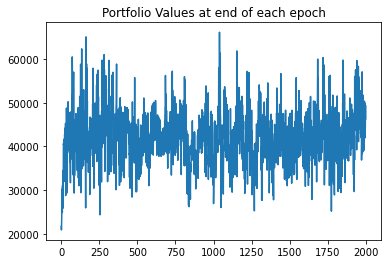

In [6]:
agent.learn(env)

In [7]:
# since we chose to turn of epsilon greedy whilist testing
# we only run one episode
agent.play_one_episode(env,training=False)

30149.35999999982

In [9]:
# Excellent results
# we get more than double our investment on the training data (on average)
# and for the test data we get 1.5x our investment which is great
# notice that our data is taken over the span of 5 years
# since our test data is half our data, this increase is over the span of 2.5 years
# maybe further tuning would yield better results
# another task for future me :)

<h1>Math</h1>

In this lecture we are going to discuss some additional results from our trading bot

---

<h3>RL Trader Discussion</h3>

Instructor's comment: Personally I am always suspicious of anything involving machine learning and trading

We might think because this agent almost always makes a profit, it must be a really good agent

Instructor's Histogram of final portfolio values (unfortunately we did not make one :( )

<img src='extras/59.4.PNG' width='400'>

However there are things we have not yet considered

---

<h3>What is our baseline?</h3>

First in order to really evaluate the agent, we have to have something to compare it to 

A reasonable benchmark we think is to see how a completely random agent performs 

That's equivalent to running a script with epsilon = 1 one or to not have an agent at all

When we do that we get a histogram like this (thats also the instructor's)

<img src='extras/59.5.PNG' width='400'>

As we can see most of the weight of the distribution is above our initial investment which means even with a totally random strategy we would probably make money 

But also there are some pretty low values here too where we have lost money

The probability of that happening is not insignificant

On average however the profit is still not bad

---

<h3>What is our baseline?</h3>

Compared to our trained agent, uur trained agent performs much better 

The probability of losing money is much less and the floor is only just under the initial investment

Of course this really depends on the hyper parameters we choose and the final values of the weights, and sometimes if we run the script we can still get results that are not much better than random

---

<h3>How can a random strategy profit?</h3>

Now we're probably wondering, how is it that even if we take purely random actions we can still make a decent profit?

Well it has to do with our data dataset 

<img src='extras/59.6.PNG' width='350'>

In general for the three stocks we chose, the value is increasing

Therefore it doesn't really matter what we do unless we always unluckily buy when the stock is high and sell when the stock is low

But if the stock is mostly going up then there's less of a chance of that happening

So one thing we can do if you really want to test this out is to test it on a set of stocks which go up and down 

A synthetic data set would be a great choice here

---

<h3>Project Extensions</h3>

Here's some other ways you could extend this project

One, we could incorporate metadata also, such as the sentiment of news articles or Twitter feeds

Of course this now becomes somewhat of an engineering problem because you have to gather all this data for every day in the span of five years 

Two, another thing you could do is incorporate past values into the state

Currently the model doesn't have any concept of the movement of stock prices

It only knows the current stock prices, the number of shares and the ininvested cash

Three, we could try using returns instead of actual prices

If we recall, extrapolation is harder than interpolation 

With stock prices which are always going up, the future stock prices will always lead to our model doing extrapolations rather than interpolations

But if we use returns instead of prices, the signal should be more stationary and we should be looking at values that don't change significantly over time